# Machine Learning with Signals Data

In this notebook we will be start using some of our machine learning techniques on signals data (audio).  We will be using a dataset consisting of recordings of spoken digits (0-9).  We will start by extracting some features from the signals and then apply our "traditional" ML algorithms, just as we did with our tabular data.  (In a future notebook we will see how to use ANNs to avoid needing to extract features.)<br><br>

If you are interested in playing around with more audio data like this, we encourage you to check out [UrbanSound](https://urbansounddataset.weebly.com).

In [ ]:
# Install Graphvis library if it is not already installed
!pip install graphviz 

# Clone the audio data repository (should cleanly fail if already downloaded)
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

# Define the path to where the data are downloaded
data_dir = './free-spoken-digit-dataset/recordings'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 13.0 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.


In [ ]:
# Import basic system and numerical packages
import os
import re
import numpy as np
import pandas as pd

# Import statistical and signal processing functions
from scipy import signal
import scipy.stats.mstats as mstats
from sklearn import metrics

# Import the scikit-learn functions and models
from sklearn.model_selection import train_test_split
from sklearn import tree

# Import audio i/o and playing functions
import scipy.io.wavfile
from IPython.display import Audio

# Import plotting functionality
import matplotlib
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns

# Setup the plotting preferencs
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

In [ ]:
# NOTE:  The sample resolution is the number of bits per sample and determines
# the number of gradations in amplitude. More info can be found here:
# http://www.asel.udel.edu/speech/tutorials/instrument/sam_res.html

# Define a function to display the pre-computed fourier transform of a signal
def plot_FT(ft, f_s):
    """
    Plots the Fourier Transform frequency spectrum
    :param ft: output of Fourier Transform (i.e., np.fft.fft())
    :param f_s: sampling frequency (or `sampling rate`) (in Hz)
    """
    # Generate the frequencies associated with the fourier transform values
    num_samples = len(ft)
    freqs = np.linspace(0, f_s, num_samples)

    # Plot and label the fourier transform amplitude values
    plt.plot(freqs[0:num_samples//2], np.abs(ft[0:num_samples//2]) * (2/num_samples))
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency [Hz]")


Let's take a look at one of the files and see what it "looks" like.

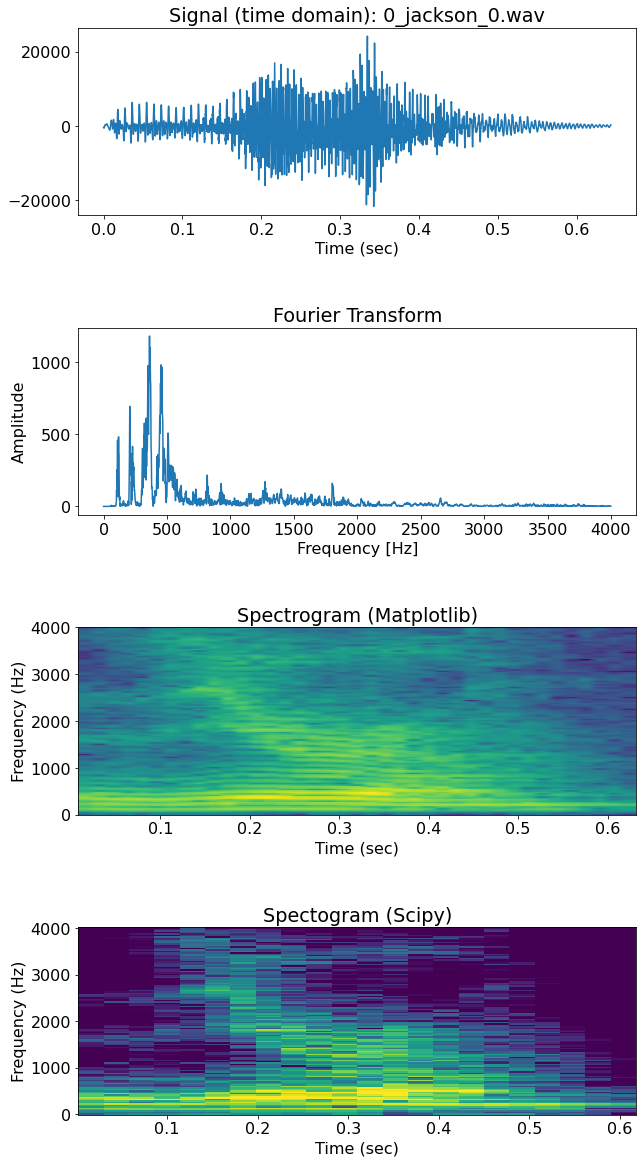

In [ ]:
# Read in an audio file: count number of samples and compute sample interval
example_file = os.path.join(data_dir,'0_jackson_0.wav')
(sample_rate, y) = scipy.io.wavfile.read(example_file)
num_samples = len(y)
sample_interval = 1.0/sample_rate

# Using np.arange allows you to easily guarantee that the *time interval*
# between samples is correct.
t = np.arange(0, num_samples/sample_rate, sample_interval)

# # Using np.linspace allows you to easily guarantee that the *number* of
# # timestamps matches the number in the audio signal.
# t = np.linspace(0, num_samples/sample_rate, num_samples, endpoint=False)

# Compute the fourier transform of the audio signal
ft = np.fft.fft(y)

# Compute the spectrogram of the audo signal
sample_freq, segment_time, spec_data = signal.spectrogram(y, sample_rate)

# Display the results to the user
plt.figure(figsize=(10, 20))

# Plot the original signal
plt.subplot(4, 1, 1)
plt.plot(t, y)
plt.xlabel('Time (sec)')
plt.title('Signal (time domain): {}'.format(os.path.basename(example_file)))

# Display the fourier transform of the signal
plt.subplot(4, 1, 2)
plot_FT(ft, sample_rate)
plt.title('Fourier Transform')

# Display the spectrogram of the signal
# (Allow Matplotlib to compute the spectrogram for you) 
plt.subplot(4, 1, 3)
plt.specgram(y, Fs=sample_rate)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram (Matplotlib)')

# Display the spectrogram of the signal
# (This is the pre-computed version from the scipy.signal.spectrogram function)
spec_data_dB = 10*np.log10(spec_data)
plt.subplot(4, 1, 4)
plt.pcolormesh(segment_time, sample_freq, spec_data_dB, vmin=0, vmax=50)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectogram (Scipy)')

# Increase padding between plots to leave room for titles and show the plots
plt.subplots_adjust(hspace=0.6)
plt.show()

In [ ]:
Audio(data=y, rate=sample_rate)

## Feature Extraction
Let's extract some features that are useful in signals processing.

### Spectral Centroid

The [**spectral centroid**](https://en.wikipedia.org/wiki/Spectral_centroid) indicates at which frequency the energy of a spectrum is centered upon. This is like a weighted mean:
$$f_c=\frac{\sum_kA(k)f(k)}{\sum_kA(k)}$$
 
where $A(k)$ is the spectral magnitude at frequency bin $k$,  $f(k)$ is the frequency at bin $k$
 .

In [ ]:
def spectral_centroid(ft, f_s):
    """
    Computes the spectral centroid from the FT of a signal

    :param ft: output of Fourier Transform (i.e., np.fft.fft())
    :param f_s: sampling frequency (or `sampling rate`) (in Hz)
    """
    # Generate the frequencies associated with the fourier transform values
    num_samples = len(ft)
    freqs = np.linspace(0, f_s, num_samples)

    # Grab the magnitude of the relevant part of the fourier transform values
    freqs = freqs[0:num_samples//2]
    magnitude = np.abs(ft[0:num_samples//2]) * (2/num_samples)
    
    # Compute the weighted frequency to get the specral centroid
    spec_centroid = np.sum(magnitude*freqs)/np.sum(magnitude)

    return spec_centroid

### Spectral Flatness

The [**spectral flatness**](https://en.wikipedia.org/wiki/Spectral_flatness), also known as Wiener entropy, is a measure used in digital signal processing to characterize an audio spectrum. Spectral flatness is typically measured in decibels, and provides a way to quantify how noise-like a sound is, as opposed to being tone-like.

In [ ]:
def spectral_flatness(ft):
    """
    Computes the spectral flatness of the FT of a signal
    
    :param ft: output of Fourier Transform (i.e., np.fft.fft())
    """
    # Grab the magnitude of the relevant part of the fourier transform values
    num_samples = len(ft)
    magnitude = abs(ft[0:num_samples//2]) * (2/num_samples)
 
    # Spectral flatness is simply the geometric mean of the FT magnitude
    # divided by the arithmetic mean of the FT magnitude
    spec_flatness = mstats.gmean(magnitude)/np.mean(magnitude)

    return spec_flatness

### Maximum Frequency Value
The frequency at maximum altitude isn't necessarily a particularly informative feature, but it's easy to extract.

In [ ]:
def max_freq(ft, f_s):
    """
    Computes the frequency with the largest magnitude in the fourier transform

    :param ft: output of Fourier Transform (i.e., np.fft.fft())
    :param f_s: sampling frequency (or `sampling rate`) (in Hz)
    """
    # Generate
    num_samples = len(ft)
    freqs = np.linspace(0, f_s, num_samples)
    
    # Grab the magnitude of the relevant portion of the fourier transform. In
    # this case we are going to ignore the `0-frequency` component in case the
    # signal was not debiased. That frequency really contains no information.
    freqs = freqs[1:num_samples//2]
    mag = np.abs(ft[1:num_samples//2]) * (2/num_samples)

    # Use the np.argmax function to locate the maximum magnitude of the FT
    max_ind = np.argmax(mag)
    max_frequency = freqs[max_ind]

    return max_frequency

### Calculate hand-engineered features for single example
This is what our one data point looks like in our dataframe:

In [ ]:
# We can use the regular expression functionality (`re` package) to robustly
# parse the name of each audio file to retrieve the digit spoken, the person
# speaking, and the trial number of that digit-speaker pair.
#
# The following lines create little "string parsers" to grab that information.
re_digit = re.compile('\d+_')
re_speaker = re.compile('_[a-z]+_')
re_trial = re.compile('_\d.')

# Use these string parsers to grab the digit, speaker, and trial from the name
# of the example_file.
digit = int(re.match(re_digit, os.path.basename(example_file))[0][:-1])
speaker = re.search(re_speaker, os.path.basename(example_file))[0][1:-1]
trial = int(re.search(re_trial, os.path.basename(example_file))[0][1:-1])

# Load this information into a dataframe and create columns to hold the
# Spectral Centroid (SC)
# Spectral Flatness (SF)
# Maximum Frequency (MF)
df = pd.DataFrame(columns=['file','digit','speaker','trial','SC','SF','MF'])

# Compute each of these audio features
sc = spectral_centroid(ft, sample_rate)
sf = spectral_flatness(ft)
mf = max_freq(ft, sample_rate)

# Add the filename, digit, speaker, trial, and audio features to the datafram
feature_dict = {'file':os.path.basename(example_file),'digit':digit,
                        'speaker':speaker,'trial':trial,'SC':sc,'SF':sf,'MF':mf}
df = df.append(feature_dict, ignore_index=True)
df

,file,digit,speaker,trial,SC,SF,MF
0,0_jackson_0.wav,0,jackson,0,849.769263,0.306077,362.15271


## Load full dataset and extract features

In [ ]:
# Create a dataframe to store the entire audio database and its features
df = pd.DataFrame(columns=['file','digit','speaker','trial','SC','SF','MF'])

# Loop over each audio file in the data directory
for audio_file in os.listdir(data_dir):
    # Try to load the file and parse all of its contents.
    # If something goes wrong, Python will execute the contents of the "except"
    # codeblock.
    try:
        # Use the same string parsers from before and grab info from filename
        digit = int(re.match(re_digit, audio_file)[0][:-1])
        speaker = re.search(re_speaker, audio_file)[0][1:-1]
        trial = int(re.search(re_trial, audio_file)[0][1:-1])

        # Read in the audio file
        full_path_to_audio_file = os.path.join(data_dir, audio_file)
        (sample_rate, y) = scipy.io.wavfile.read(full_path_to_audio_file)
        
        # If the audio recording is in stereo (2-channels), just use one of them
        if len(y.shape) == 2:
            y = y[:,0]

        # Grab the number of samples, compute the sample interval, and generate
        # the time-stamps for each of the audio samples
        num_samples = len(y)
        sample_interval = 1.0/sample_rate
        t = np.arange(0, num_samples/sample_rate, sample_interval)

        # Compute the Fourier Transform of the audio signal
        ft = np.fft.fft(y)

        # Calculate the audio features to be stored in the data fram
        sc = spectral_centroid(ft, sample_rate)
        sf = spectral_flatness(ft)
        mf = max_freq(ft, sample_rate)

        # Add the info for this file to our dataframe
        feature_dict = {'file':os.path.basename(audio_file),'digit':digit,
                        'speaker':speaker,'trial':trial,'SC':sc,'SF':sf,'MF':mf}
        df = df.append(feature_dict, ignore_index=True)

    except Exception as err:
        # Something went wrong!  =(
        # Notife the user of the audio file that broke and what the error was
        print(audio_file)
        raise err

In [ ]:
# Print the head of the dataframe
print('df.head():\n')
print(df.head(15))

# Also print some summary information about the dataframe
print('\n\ndf.info():\n')
print(df.info())

df.head():

                 file digit   speaker trial           SC        SF          MF
0    6_nicolas_13.wav     6   nicolas     1  1119.381463  0.473699  430.863254
1    3_jackson_46.wav     3   jackson     4  1082.079907  0.362998  352.529727
2     4_george_25.wav     4    george     2  1110.354451  0.348319  479.197403
3    1_jackson_35.wav     1   jackson     3   794.082061  0.251731  468.224064
4    5_nicolas_18.wav     5   nicolas     1   982.587101  0.378095  236.517219
5    2_nicolas_24.wav     2   nicolas     2  1101.094185  0.430648  289.488800
6     0_george_26.wav     0    george     2  1750.716191  0.414188  459.919028
7       4_theo_17.wav     4      theo     1   646.996754  0.223317  264.868179
8     8_george_20.wav     8    george     2  2024.477837  0.380585  459.363958
9       6_theo_46.wav     6      theo     4  1319.755519  0.521487  484.097945
10     9_lucas_36.wav     9     lucas     3   924.182068  0.341937   92.579986
11   8_nicolas_39.wav     8   nicolas   

In [ ]:
# Visualize a pairplot of the spectral features. In this instance, color each
# datapoint by the *person* speaking the digit to see if each *speaker* has a
# distinguishable set of spectral characteristics (e.g., deep vs high voice)
g = sns.pairplot(data=df, vars=['SC', 'SF', 'MF'],
                 hue='speaker', corner=True)
plt.suptitle('Spectral Features (colored by speaker)', x=0.5, y=1.02)

# Clean up the plot appearance
plt.gcf().tight_layout()

# Repeat this plot, but now color each datapoint by the *digit* being spoken to
# see if each *word* has a distinguishable set of spectral characteristics
# (e.g., does the buzzing 'z' in 'zero' cause a different set of characteristics
# than the shap 't' sound in 'two'?)
g = sns.pairplot(data=df, vars=['SC', 'SF', 'MF'],
                 hue='digit', corner=True)
plt.suptitle('Spectral Features (colored by digit)', x=0.5, y=1.02)

# Clean up the plot appearance
plt.gcf().tight_layout()

NameError: name 'sns' is not defined

# Train Machine Learning Algorithm

With these example features in hand, we can build a classification tool using some of the machine learning techniques from previous notebooks.

## Prepare Training Data

As a first step in this process, we specify which column of the dataframe contains the 'label' information. We also specify the complete set of features to be used in the classification process. This should generally be *all* of the columns except for the one being used as the 'label,' and it should not contain any of the columns generated from the filename because these do not actually contain information about the audio content.

(Note: we use the builtin Python [set object](https://docs.python.org/3.6/library/stdtypes.html#set-types-set-frozenset) to quickly process the dataframe columns.)

In [ ]:
# Select the name of the column to be used as the desired 'label' output
label = 'speaker'

# Create a list of features to be used in the classification process.
# We use the 'set' object in Python to quickly remove the unwanted columns
features = set(df.columns) - set([label, 'file', 'trial'])
features = list(features)

print('Classifying {} using...'.format(label))
print('features: {}'.format(features))

Classifying speaker using...
features: ['SC', 'MF', 'digit', 'SF']


Our next step is to convert each of the columns with discrete values (e.g., speaker, digit, trial) into the Pandas.Categorial data type. This creates a unique numerical encoding for each entry so that string values (such as speaker names) can be easily treated as numerical values.

In [ ]:
# Convert the data in the 'speaker', 'digit', and 'trial' columns of the
# dataframe into the 'Categorical' type.
df.speaker = pd.Categorical(df.speaker)
df.digit = pd.Categorical(df.digit)
df.trial = pd.Categorical(df.trial)

If the the speaker is one of the features to be used, then we need swap out its numerical representation so that we can perform computations on it.

In [ ]:
# If the speaker is in the set of features used to classify the audio files,
# then the string speaker value should be converted to its numerical version.
if 'speaker' in features:
    # Add a column containing the numerically encoded version of speaker name
    df['speaker_code'] = df.speaker.cat.codes

    # Replace the 'speaker' feature with the 'speaker_code' feature
    features.remove('speaker')
    features.append('speaker_code')

    # Double check that there are not duplicate entries in the list of features
    # by converting to a `set` object (which automatically removes duplicate
    # entries) then convert back `list` object.
    features = list(set(features))

# Update the user on what columns and content remain in the datafram
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   file     3000 non-null   object  
 1   digit    3000 non-null   category
 2   speaker  3000 non-null   category
 3   trial    3000 non-null   category
 4   SC       3000 non-null   float64 
 5   SF       3000 non-null   float64 
 6   MF       3000 non-null   float64 
dtypes: category(3), float64(3), object(1)
memory usage: 103.6+ KB


Next we split the data into training and test sets.

In [ ]:
# split X and y into training and testing sets
# NOTE: Using convention that X = features, y = label
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:,features], df[label], test_size=0.25,
    random_state=0, stratify = df[label])

Now, with the correct training features and labels, we can train a machine learning classification model. To start with, let's consider a decision tree.

In [ ]:
# Instantiate a DecisionTree model
model = tree.DecisionTreeClassifier(max_depth=4)

# Fit the model to the training data
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

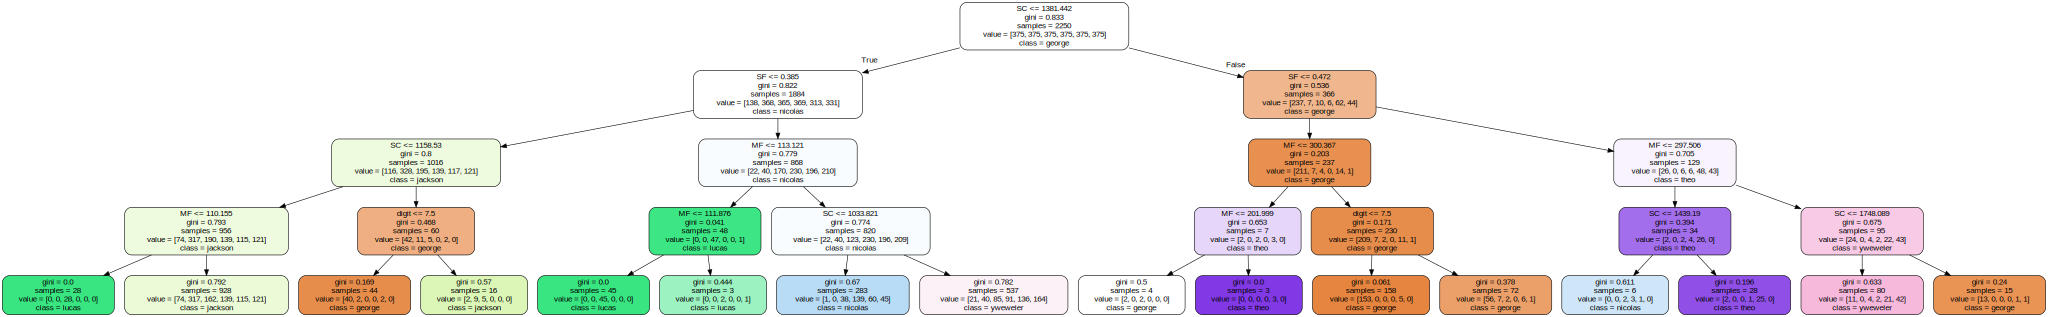

In [ ]:
# Convert each class name into a string representation
class_names = [str(c) for c in model.classes_]

# Generate the data to visualize the decision tree
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=features,  
                         class_names=class_names,  
                         filled=True, rounded=True) 

# Visualize the tree from that exported data
graph = graphviz.Source(dot_data)  
graph

## Evaluate on Test Data

In [ ]:
# Visualize the confusion matrix
def plot_cmatrix(cm,labels,title='Confusion Matrix'):
    """
    Plot the confusion matrix for the classifier

    :param cm: the actual confusion matrix
    :param labels: the labels to add along the axes of the matrix
    :param title: the title to place over the confusion matrix plot
    """
    # Generate a new figure and axes instance
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Display the confusion matrix (attempt to account for normalization)
    row_totals = np.sum(cm, axis=1)
    vmax_val = row_totals.max() if row_totals.max() > 1 else 1.0
    ax_im = ax.imshow(cm, cmap='Reds', vmin=0, vmax=vmax_val)

    # Annotate the figure
    plt.title(title, fontsize=20)
    fig.colorbar(ax_im)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=16, rotation=70)
    ax.set_yticklabels(labels, fontsize=16)
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('True', fontsize=16)
    plt.show()

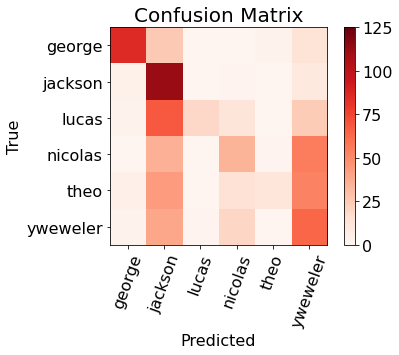

In [ ]:
# Predict class label probabilities
labels=np.sort(y_test.unique())
y_test_pred = model.predict(X_test)

cm = metrics.confusion_matrix(y_test,y_test_pred)
plot_cmatrix(cm, labels)

# Conclusion

This is just a tutorial on how to get this process running. The real challenge is in designing appropriate features to adequately separate out the classes. You should also consider the possibility of using *other* classification models (KNN, logistic regression, etc...).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0dae1723-b0cb-437a-aac4-0c44d9b10b1b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>